Question 1. (Deterministic policy)
\begin{align*}
    V^{\pi_{D}}(s) &= Q^{\pi_{D}}(s, \pi_{D}(s))\\
    Q^{\pi_{D}}(s,a) &= R(s,a) + \gamma \cdot \sum_{s^\prime} P(s,a,s^\prime)V^{\pi_{D}}(s^\prime)\\
    V^{\pi_{D}}(s) &= R(s,\pi_{D}(s)) + \gamma \cdot \sum_{s^\prime} P(s,\pi_{D}(s),s^\prime)V^{\pi_{D}}(s^\prime)\\
    Q^{\pi_{D}}(s,a) &= R(s,a) + \gamma \cdot \sum_{s^\prime} P(s,a,s^\prime)Q^{\pi_{D}}(s^\prime, \pi_{D}(s^\prime))
\end{align*}

Question 2. (Bellman Equation)
By Bellman Equation, we get
\begin{align*}
    V^*(s) = \max_{a} \big\{(a(1-a) + (1-a)(1+a)) + \gamma \cdot \sum_{s^\prime} a V^*(s+1) + (1-a) V^*(s) \big\}
\end{align*}
Due to the structure of the transition probabilities, the optimal value function $V^*(s)$ should be a constant for any state $s$. Then we get
\begin{align*}
    (1 - \gamma)\cdot V^*(s) = \max_{a} \big\{(a(1-a) + (1-a)(1+a))\big\} = \frac{9}{4}.
\end{align*}
And thus the optimal policy is:
\begin{align*}
    \pi(s): S \rightarrow \mathcal{A} = \arg\max_{a} \big\{(a(1-a) + (1-a)(1+a)) \big\} = \frac{1}{4}.
\end{align*}

Question 3.
(1). The state space is: $\{0,1,...,n\}$, with ${0,n}$ to be terminal states. The action space is: $\{A, B\}$ for each state. The transition-reward function we set is as follows, where we set the reward when arriving at $n$ to be $1$, $0$ to be $-1$ and $0$ otherwise.
\begin{align*}
    &P(s, A) =
    \left\{
    \begin{array}{lllll}
        &(i-1, -1),\quad\text{if}~i=1;&& (i-1, 0), \text{otherwise}, &w.p. \frac{i}{n},\\
        &(i+1, 1),\quad\text{if}~i = n-1;&& (i+1, 0), \text{otherwise}, &w.p. \frac{n-i}{n}.
    \end{array}
    \right.\\

    &P(s, B) = \text{Uniform}\{(0, -1), (1, 0),\dots,(n-1, 0), (n, 1)\}.
\end{align*}

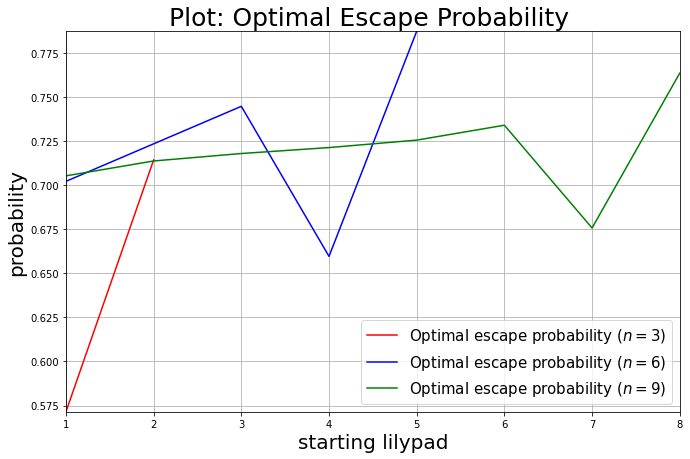

[For State 1: Do Action B
For State 2: Do Action A
,
 For State 1: Do Action B
For State 2: Do Action A
For State 3: Do Action A
For State 4: Do Action A
For State 5: Do Action A
,
 For State 1: Do Action B
For State 2: Do Action A
For State 3: Do Action A
For State 4: Do Action A
For State 5: Do Action A
For State 6: Do Action A
For State 7: Do Action A
For State 8: Do Action A
]


In [24]:
from rl.markov_decision_process import FiniteMarkovDecisionProcess, S, A
from rl.distribution import FiniteDistribution, Categorical
from typing import Mapping, Tuple, Sequence, Callable
from rl.policy import FiniteDeterministicPolicy
from rl.markov_process import FiniteMarkovRewardProcess
import operator
from pprint import pprint

#construct the frog MDP
def frog_escape(n: int)-> FiniteMarkovDecisionProcess:
    reward_transition_map: Mapping[S, Mapping[A, FiniteDistribution[Tuple[S, float]]]] = {}
    uni_dist = {(i, 0): 1/(n+1) for i in range(2,n)}
    uni_dist.update({(0, -1): 1/(n+1), (n, 1): 1/(n+1)})
    distB: FiniteDistribution[Tuple[S, float]] = \
        Categorical(uni_dist)
    for i in range(2,n-1):
        distA: FiniteDistribution[Tuple[S, float]] = \
        Categorical({(i-1, 0): i/n, (i+1, 0): (n-i)/n})
        reward_transition_map[i] = {"A": distA, "B": distB}
    reward_transition_map[1] = {
        "A": Categorical({(0, -1): 1/n, (2, 0): (n-1)/n}),
        "B": distB
    }
    reward_transition_map[n-1] = {
        "A": Categorical({(n-2, 0): (n-1)/n, (n, 1): 1/n}),
        "B": distB
    }
    return FiniteMarkovDecisionProcess(reward_transition_map)

#construct all possible deterministic policy
def possible_AB (n: int) -> Sequence[Sequence[A]]:
    if n == 1: return ['A', 'B'] #base case
    else:
        a: Sequence[A] = [str + 'A' for str in possible_AB(n - 1)]
        b: Sequence[A] = [str + 'B' for str in possible_AB(n - 1)]
        return a + b

def possible_deter (
    n: int #number of lilypads
) -> Sequence[FiniteDeterministicPolicy]:
    possible_policies_map: Sequence[Mapping[S,A]] = [{i: str[i-1] for i in range(1,n)} for str in possible_AB(n - 1)]
    possible_policies: Sequence[FiniteDeterministicPolicy] = [FiniteDeterministicPolicy(action_for = map) for map in possible_policies_map]
    return possible_policies

def opt_val_pol (
    n: int
) -> Tuple[Mapping[S, A], Mapping[S, float]]:
    val_seq: Sequence[Tuple[float, Sequence[float], Mapping[S, float]]] = []

    for pol in possible_deter(n):
        frog_mrp: FiniteMarkovRewardProcess = frog_escape(n).apply_finite_policy(policy = pol)
        opt_vec: Sequence[float] = frog_mrp.get_value_function_vec(gamma = 1.)
        val_seq += [(sum(opt_vec), opt_vec, pol)]

    opt_result = max(val_seq, key=operator.itemgetter(0))[1:]

    return opt_result

def escape_prob (
        n :int
) -> Sequence[float]:
    return (opt_val_pol(n)[0] + 1)/2

from rl.gen_utils.plot_funcs import plot_list_of_curves

plot_list_of_curves(
        [range(1, 3), range(1, 6), range(1, 9)] ,
        [escape_prob(3), escape_prob(6), escape_prob(9)],
        ["r", "b", "g"],
        [
            r"Optimal escape probability ($n=3$)",
            r"Optimal escape probability ($n=6$)",
            r"Optimal escape probability ($n=9$)"
        ],
        "starting lilypad",
        "probability",
        "Plot: Optimal Escape Probability "
    )

pprint([opt_val_pol(n)[1] for n in [3,6,9]])

So the pattern will be: tend to choose action B except in state 1.

Question 4. (Minimize infinite-horizon cost with γ = 0)
Since $\gamma = 0$, we have
\begin{align*}
    Q(s,a) &= E[\exp(a s^\prime) | s, a] \\
    &= \int_{\mathbb{R}} \exp(a s^\prime) \frac{1}{\sqrt{2 \pi} \sigma} \exp(-\frac{(s^\prime - s)^2}{2\sigma^2}) d s^\prime \\
    &= \exp(-\frac{1}{2\sigma^2}(s^2 - (s+ a\sigma^2)^2)).
\end{align*}
Therefore, the optimal policy is:
\begin{align*}
    \pi^*(s): S \rightarrow \mathcal{A} = - \frac{s}{\sigma^2}.
\end{align*}
And the optimal cost is: $\exp(-\frac{s^2}{2\sigma^2})$.